# Adaboost(分類)

<iframe width="560" height="315" src="https://www.youtube.com/embed/1K-h4YzrnsY" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [1]:
# Google　Colaboratory で実行する場合はインストールする
if str(get_ipython()).startswith("<google.colab."):
    !pip install japanize_matplotlib

In [2]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [3]:
# 表示する文字サイズを調整
plt.rc("font", size=20)
plt.rc("legend", fontsize=16)
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)

# 乱数
np.random.seed(777)

# 実験用のデータを作成

In [4]:
# 特徴が20あるデータを作成
n_features = 20
X, y = make_classification(
    n_samples=2500,
    n_features=n_features,
    n_informative=10,
    n_classes=2,
    n_redundant=4,
    n_clusters_per_class=5,
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Adaboostモデルを訓練

```{hint}
[sklearn.ensemble.StackingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
```

In [5]:
ab_clf = AdaBoostClassifier(
    n_estimators=10,
    learning_rate=1.0,
    random_state=117117,
    base_estimator=DecisionTreeClassifier(max_depth=2),
)
ab_clf.fit(X_train, y_train)

y_pred = ab_clf.predict(X_test)
ab_clf_score = roc_auc_score(y_test, y_pred)

ab_clf_score

0.7546477034876885

## learning-rateの影響

In [6]:
scores = []
learning_rate_list = np.linspace(0.01, 1, 100)
for lr in learning_rate_list:
    ab_clf_i = AdaBoostClassifier(
        n_estimators=10,
        learning_rate=lr,
        random_state=117117,
        base_estimator=DecisionTreeClassifier(max_depth=2),
    )
    ab_clf_i.fit(X_train, y_train)

    y_pred = ab_clf_i.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))

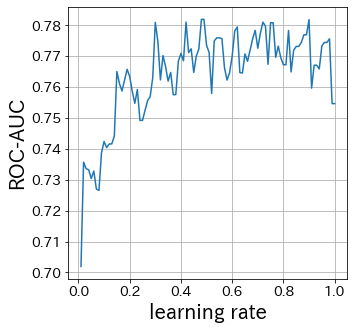

In [7]:
plt.figure(figsize=(5, 5))
plt.plot(learning_rate_list, scores)
plt.xlabel("learning rate")
plt.ylabel("ROC-AUC")
plt.grid()
plt.show()

## n_estimatorsの影響

In [8]:
scores = []
n_estimators_list = [int(ne) for ne in np.linspace(5, 70, 40)]
for n_estimators in n_estimators_list:
    ab_clf_i = AdaBoostClassifier(
        n_estimators=int(n_estimators),
        learning_rate=0.6,
        random_state=117117,
        base_estimator=DecisionTreeClassifier(max_depth=2),
    )
    ab_clf_i.fit(X_train, y_train)

    y_pred = ab_clf_i.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))

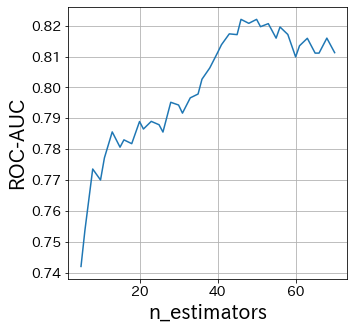

In [9]:
plt.figure(figsize=(5, 5))
plt.plot(n_estimators_list, scores)
plt.xlabel("n_estimators")
plt.ylabel("ROC-AUC")
plt.grid()
plt.show()

## base-estimatorの影響

In [10]:
scores = []
base_estimator_list = [
    DecisionTreeClassifier(max_depth=md) for md in [2, 3, 4, 5, 6, 7, 8, 9, 10]
]
for base_estimator in base_estimator_list:
    ab_clf_i = AdaBoostClassifier(
        n_estimators=10,
        learning_rate=0.5,
        random_state=117117,
        base_estimator=base_estimator,
    )
    ab_clf_i.fit(X_train, y_train)

    y_pred = ab_clf_i.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))

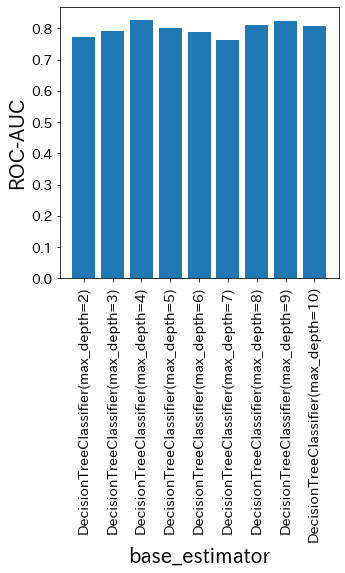

In [11]:
plt.figure(figsize=(5, 5))
plt_index = [i for i in range(len(base_estimator_list))]
plt.bar(plt_index, scores)
plt.xticks(plt_index, [str(bm) for bm in base_estimator_list], rotation=90)
plt.xlabel("base_estimator")
plt.ylabel("ROC-AUC")
plt.show()

# Adaboostのデータの重みの可視化
分類がしにくいデータに対して重みを割り当てる様子を可視化します。

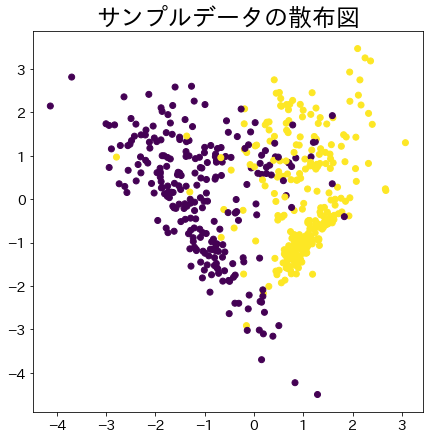

In [12]:
# NOTE: モデルに渡されるsample_weightを確認するために作成したモデル
class DummyClassifier:
    def __init__(self):
        self.model = DecisionTreeClassifier(max_depth=3)
        self.n_classes_ = 2
        self.classes_ = ["A", "B"]
        self.sample_weight = None  # sample_weight

    def fit(self, X, y, sample_weight=None):
        self.sample_weight = sample_weight
        self.model.fit(X, y, sample_weight=sample_weight)
        return self.model

    def predict(self, X, check_input=True):
        proba = self.model.predict(X)
        return proba

    def get_params(self, deep=False):
        return {}

    def set_params(self, deep=False):
        return {}


n_samples = 500
X_2, y_2 = make_classification(
    n_samples=n_samples,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    random_state=117,
    n_clusters_per_class=2,
)

plt.figure(
    figsize=(
        7,
        7,
    )
)
plt.title(f"サンプルデータの散布図")
plt.scatter(X_2[:, 0], X_2[:, 1], c=y_2)
plt.show()

## ブースティングが進んだ後の重み

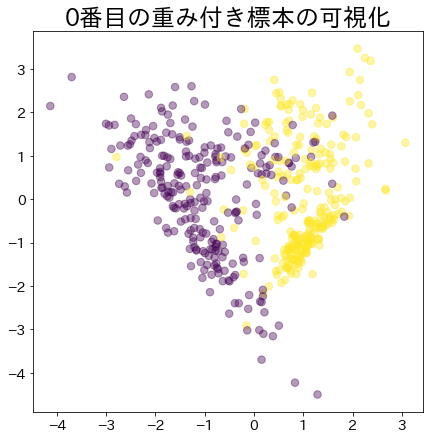

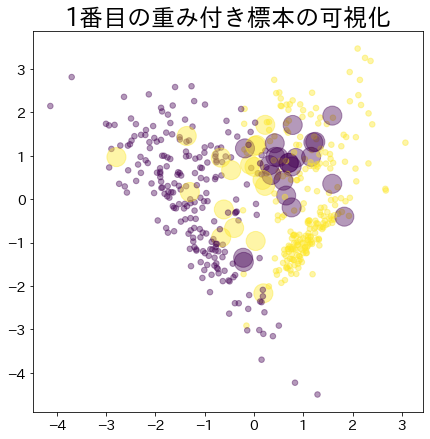

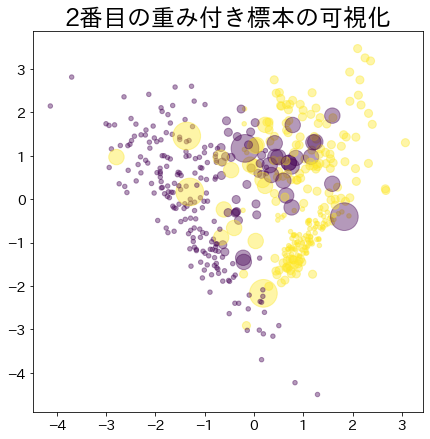

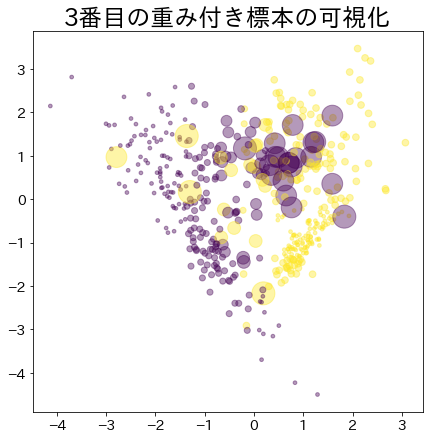

In [13]:
clf = AdaBoostClassifier(
    n_estimators=4, random_state=0, algorithm="SAMME", base_estimator=DummyClassifier()
)
clf.fit(X_2, y_2)

for i, estimators_i in enumerate(clf.estimators_):
    plt.figure(
        figsize=(
            7,
            7,
        )
    )
    plt.title(f"{i}番目の重み付き標本の可視化")
    plt.scatter(
        X_2[:, 0],
        X_2[:, 1],
        marker="o",
        c=y_2,
        alpha=0.4,
        s=estimators_i.sample_weight * n_samples ** 1.65,
    )
    plt.show()